In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
import scipy

import sys
sys.path.append('../../..')
import mutagenesisfunctions as mf
import helper
from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency

from Bio import AlignIO
import time as time
import pandas as pd
#---------------------------------------------------------------------------------------------------------------------------------
'''DEFINE ACTIONS'''
TRAIN = False
TEST = False
WRITE = False
FOM = False
SOMCALC = False
SOMVIS = True

if '--train' in sys.argv:
  TRAIN = True
if '--test' in sys.argv:
  TEST = True
if '--write' in sys.argv:
  WRITE = True
if '--fom' in sys.argv:
  FOM = True
if '--somcalc' in sys.argv:
  SOMCALC = True
if '--somvis' in sys.argv:
  SOMVIS = True

#---------------------------------------------------------------------------------------------------------------------------------
'''DEFINE LOOP'''

exp = 'rnasep'  #for the params folder


img_folder = 'Images_mlp'
if not os.path.isdir(img_folder):
  os.mkdir(img_folder)
#---------------------------------------------------------------------------------------------------------------------------------

'''OPEN DATA'''

starttime = time.time()

#Open data from h5py
filename = 'rnasep_full.hdf5'
with h5py.File(filename, 'r') as dataset:
    X_data = np.array(dataset['X_data'])
    Y_data = np.array(dataset['Y_data'])

numdata, seqlen, _, dims = X_data.shape
dims = dims-1

#remove gaps from sequences
ungapped = True
if ungapped:
    X_data = X_data[:, :, :, :dims]

# get validation and test set from training set
train_frac = 0.8
valid_frac = 0.1
test_frac = 1-0.8-valid_frac
N = numdata
posidx = np.random.permutation(np.arange(N//2))
negidx = np.random.permutation(np.arange(N//2, N))
split_1 = int((N//2)*(1-valid_frac-test_frac))
split_2 = int((N//2)*(1-test_frac))
#shuffle = np.random.permutation(N)

trainidx = np.random.permutation(np.concatenate([posidx[:split_1], negidx[:split_1]]))
valididx = np.random.permutation(np.concatenate([posidx[split_1:split_2], negidx[split_1:split_2]]))
testidx = np.random.permutation(np.concatenate([posidx[split_2:], negidx[split_2:]]))

#set up dictionaries
train = {'inputs': X_data[trainidx],
         'targets': Y_data[trainidx]}
valid = {'inputs': X_data[valididx],
         'targets': Y_data[valididx]}
test = {'inputs': X_data[testidx],
         'targets': Y_data[testidx]}

print ('Data extraction and dict construction completed in: ' + mf.sectotime(time.time() - starttime))

simalign_file = 'rnasep_full.sto'
#Get the full secondary structure and sequence consensus from the emission
SS = mf.getSSconsensus(simalign_file)
SQ = mf.getSQconsensus(simalign_file)

#Get the ungapped sequence and the indices of ungapped nucleotides
_, ugSS, ugidx = mf.rm_consensus_gaps(X_data, SS)
_, ugSQ, _ = mf.rm_consensus_gaps(X_data, SQ)


#Get the sequence and indices of the conserved base pairs
bpchars = ['(',')','<','>','{','}','[',']']
sig_bpchars = ['<','>']
bpidx, bpSS, nonbpidx = mf.sigbasepair(SS, bpchars)
numbp = len(bpidx)
numug = len(ugidx)

#Get the bpug information
bpugSQ, bpugidx = mf.bpug(ugidx, bpidx, SQ)
print (numug, numbp, seqlen)
#---------------------------------------------------------------------------------------------------------------------------------



Data extraction and dict construction completed in: 2.37s
367 204 3188


/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


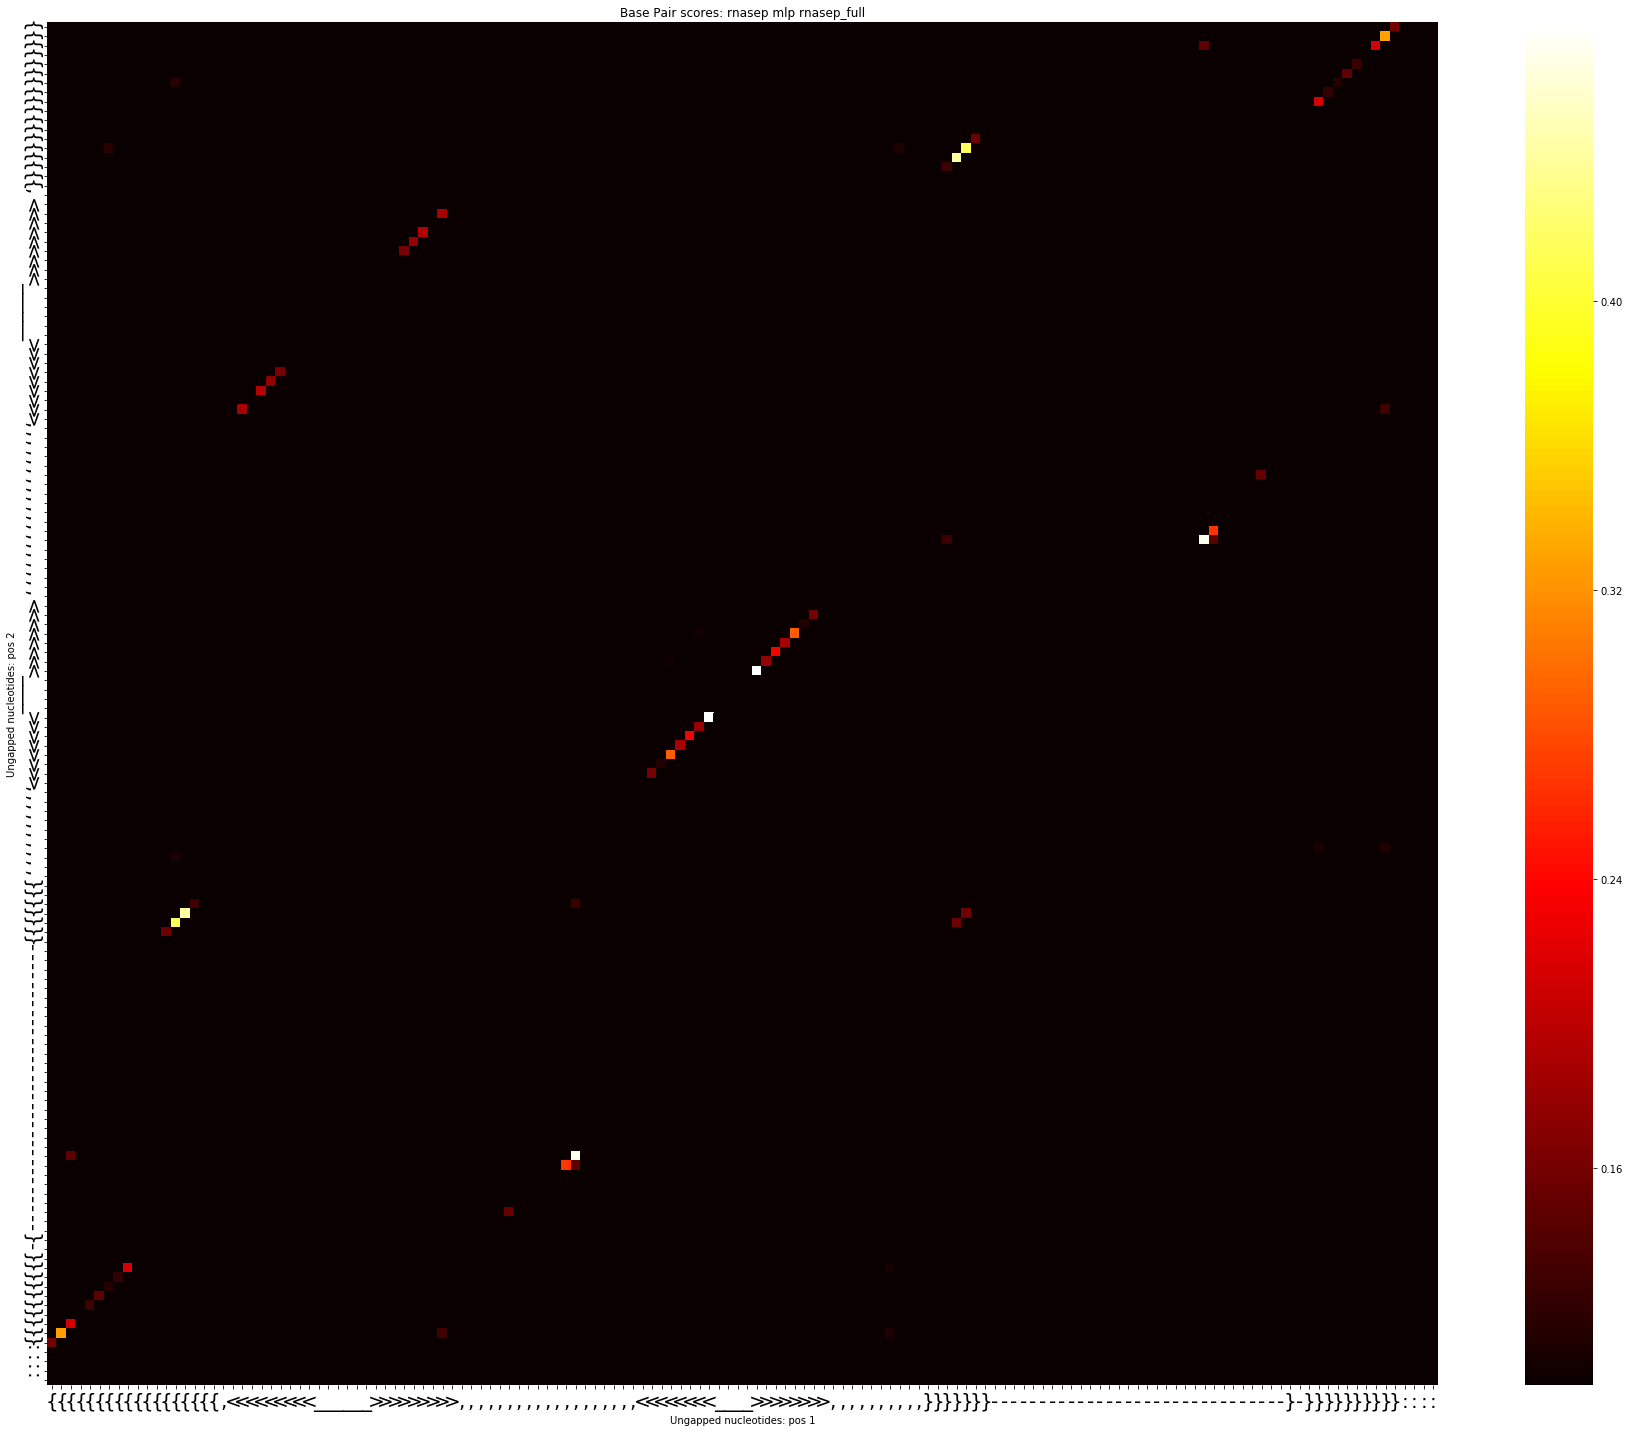

In [4]:


'''SAVE PATHS AND PARAMETERS'''
params_results = '../../results'

modelarch = 'mlp'
trial = 'rnasep_full'
modelsavename = '%s_%s'%(modelarch, trial)


if SOMVIS:
  #Load the saved data
  num_summary = np.min([500,len(test['inputs'])//2])
  arrayspath = 'Arrays/%s_%s%s_so%.0fk.npy'%(exp, modelarch, trial, num_summary/1000)
  mean_mut2 = np.load(arrayspath)

  #Reshape into a holistic tensor organizing the mutations into 4*4
  meanhol_mut2 = mean_mut2.reshape(numug,numug,4,4)

  #Normalize
  normalize = True
  if normalize:
      norm_meanhol_mut2 = mf.normalize_mut_hol(meanhol_mut2, normfactor=1)

  #Let's try something weird
  bpfilter = np.ones((4,4))*0.
  for i,j in zip(range(4), range(4)):
      bpfilter[i, -(j+1)] = +1.

  nofilter = np.ones((4,4))

  C = (norm_meanhol_mut2*bpfilter)
  C = np.sum((C).reshape(numug,numug,dims*dims), axis=2)
  C = C - np.mean(C)
  C = C/np.max(C)

  plt.figure(figsize=(25,20))
  #plt.subplot(1,2,1)
  n_C = C[n_ugidx][:, n_ugidx]
  #n_C = n_C - np.mean(n_C)
  #n_C = n_C/np.max(n_C)
  g = sb.heatmap(n_C,xticklabels=n_ugSS, yticklabels=n_ugSS,vmin=0.1, cmap='hot', linewidth=0.0)
  #g = sb.heatmap(C,xticklabels=ugSS, yticklabels=ugSS,vmin=None, cmap='hot', linewidth=0.0)
  plt.title('Base Pair scores: %s %s %s'%(exp, modelarch, trial))
  plt.xlabel('Ungapped nucleotides: pos 1')
  plt.ylabel('Ungapped nucleotides: pos 2')
  plt.xticks(rotation=0, fontsize=20)
  plt.yticks(rotation=270, fontsize=20)
  
  #plt.subplot(1,2,2)
  #sb.heatmap(C[bpugidx][:, bpugidx], xticklabels=bpSS, yticklabels=bpSS, vmin=0., cmap='Blues', linewidth=0.0)
  #plt.title('Base Pair score for the base paired consensus regions given by infernal')
  #plt.xlabel('Base Paired nucleotides: pos 1')
  #plt.ylabel('Base Paired nucleotides: pos 2')


  som_file = modelsavename + 'SoM_bpfilter' + '.png'
  som_file = os.path.join(img_folder, som_file)
  plt.show()
  #plt.savefig(som_file)
  #plt.close()

In [2]:
ugSS

'{{{{{{{{{{{{{{{{{{,<<<<<<<<<______>>>>>>>>>,,,,,,,,,,,,,[[[[--------[[[[[<<<<<_____>>>>><<<<<____>>>>->((---(((((,,,,,,,,,,,,<<<<<<<<<<<____>>>>>>>>>-->>,,,,,,,<<<<<<_______>>>>>><<<<<<<<<____>>>>>>>>->,,)))--))))]]]]]]]]],,,<<<<------<<<<<<-----<<<<<_____>>>>>->>>>>>----->>>>,,,,,,<<<<<<<<____>>>>>>>>,,,,,,,,,,}}}}}}}-------------------------------}-}}}}}}}}}}::::'

[:73] + [213:]

In [10]:
ugSS[:56]

'{{{{{{{{{{{{{{{{{{,<<<<<<<<<______>>>>>>>>>,,,,,,,,,,,,,'

In [11]:
ugSS[277:]

',,,,,,<<<<<<<<____>>>>>>>>,,,,,,,,,,}}}}}}}-------------------------------}-}}}}}}}}}}::::'

In [12]:
n_ugSS = ugSS[:56] + ugSS[277:]
n_ugSS
n_ugidx = [i for i in range(56)] + [i for i in range(277,len(ugSS))]

In [13]:
len(bpugidx)

204

In [14]:
import bpdev as bd
def plot_true(ugSS, bpugSQ, numug):
    s = bd.get_true(ugSS, numug)
    s = s[n_ugidx][:, n_ugidx]

    #visualize in the same shape as a wc plot
    plt.figure(figsize=(25,20))
    sb.heatmap(s,xticklabels=n_ugSS, yticklabels=n_ugSS, vmin=None, cmap='hot', linewidth=0.0)
    plt.title('True base pairs taken from stockholm SS')
    plt.xlabel('Ungapped nucleotides: pos 1')
    plt.ylabel('Ungapped nucleotides: pos 2')
    return (s)

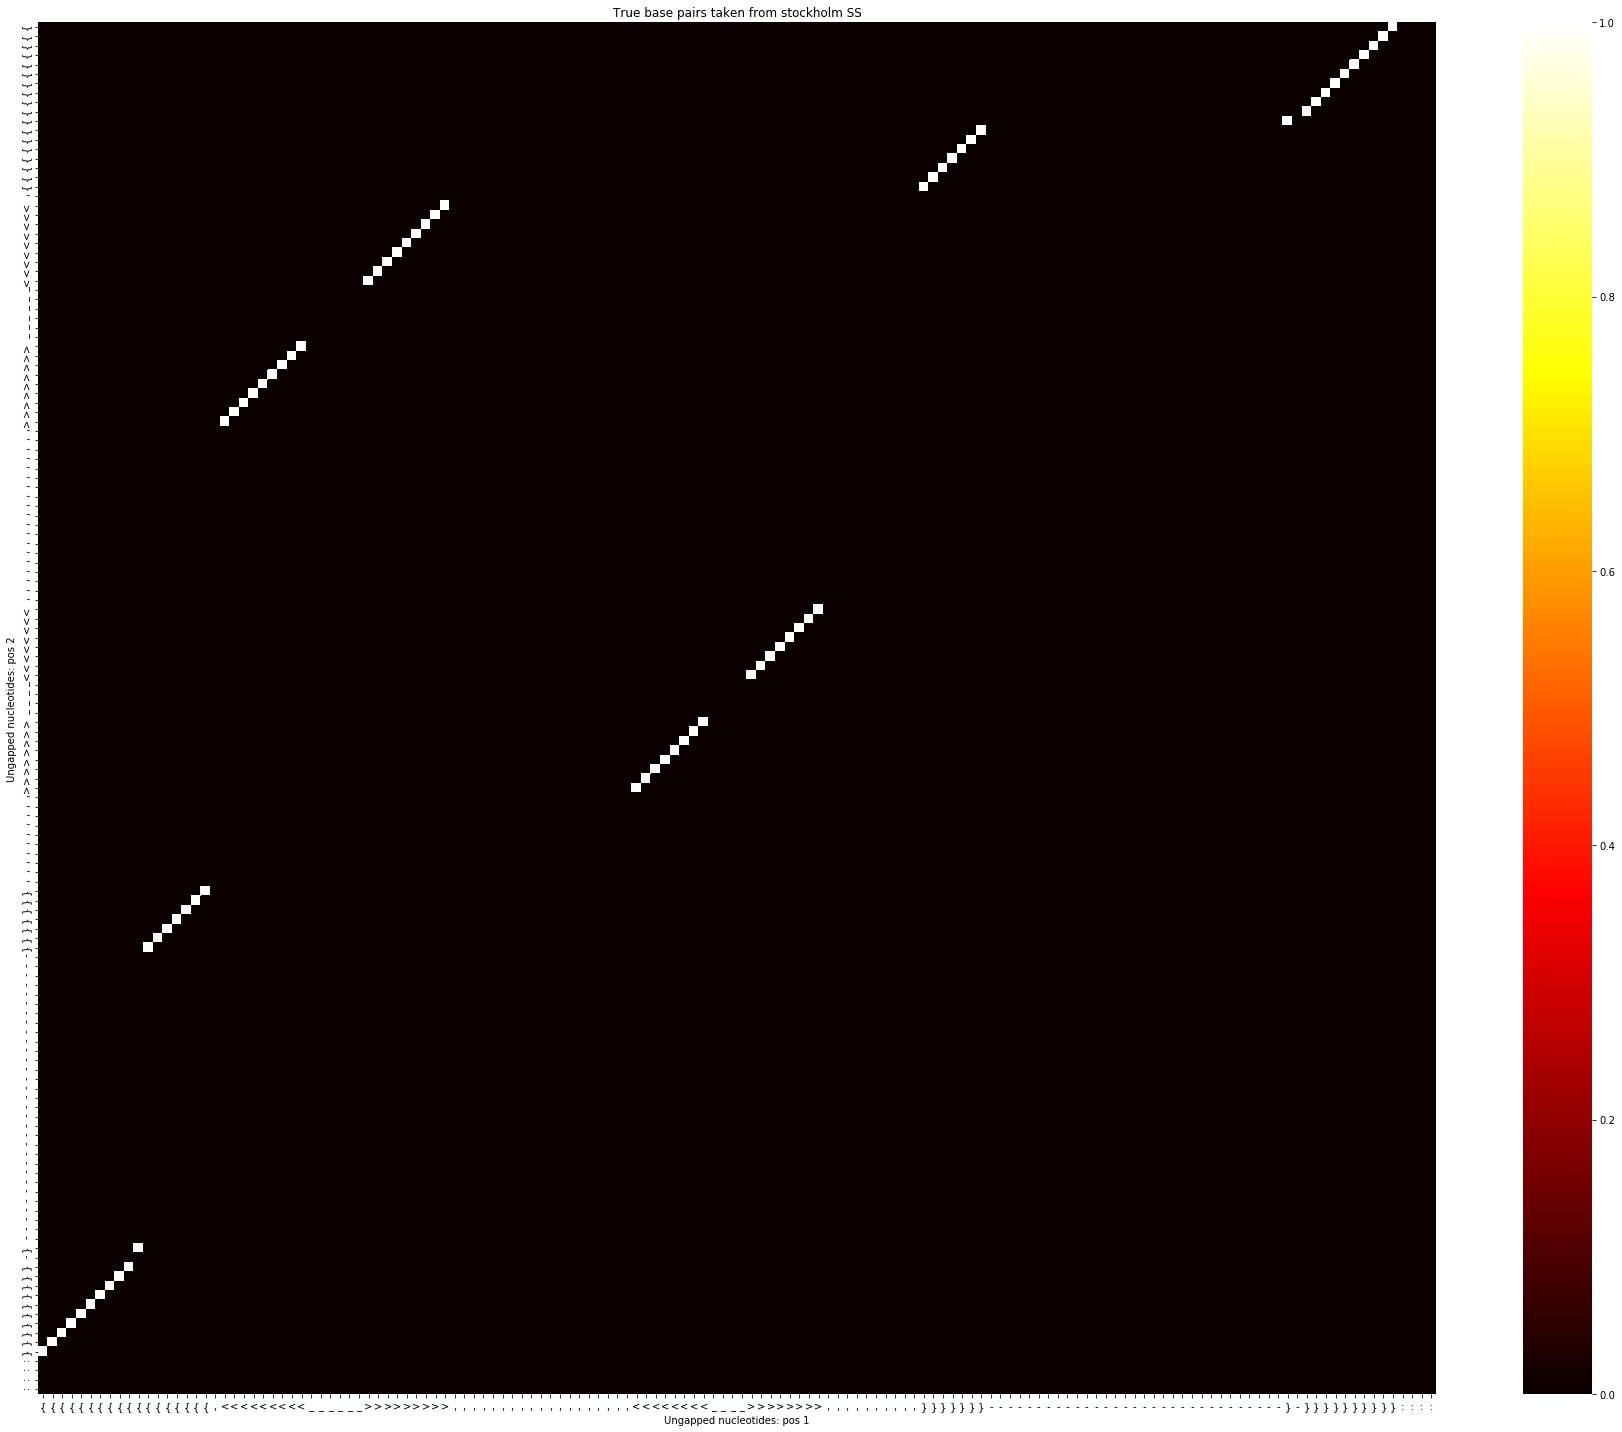

In [15]:
%matplotlib inline
s = plot_true(ugSS, bpugSQ, numug)

In [16]:
def mergearrays(C,S):
    blocklen = len(C)
    new = np.copy(C)
    new[np.arange(blocklen), np.arange(blocklen)] = 0.28
    new[np.triu_indices(blocklen, 1)] = S[np.triu_indices(blocklen, 1)]
    
    return (new)
    

In [17]:
me = mergearrays(n_C, s)

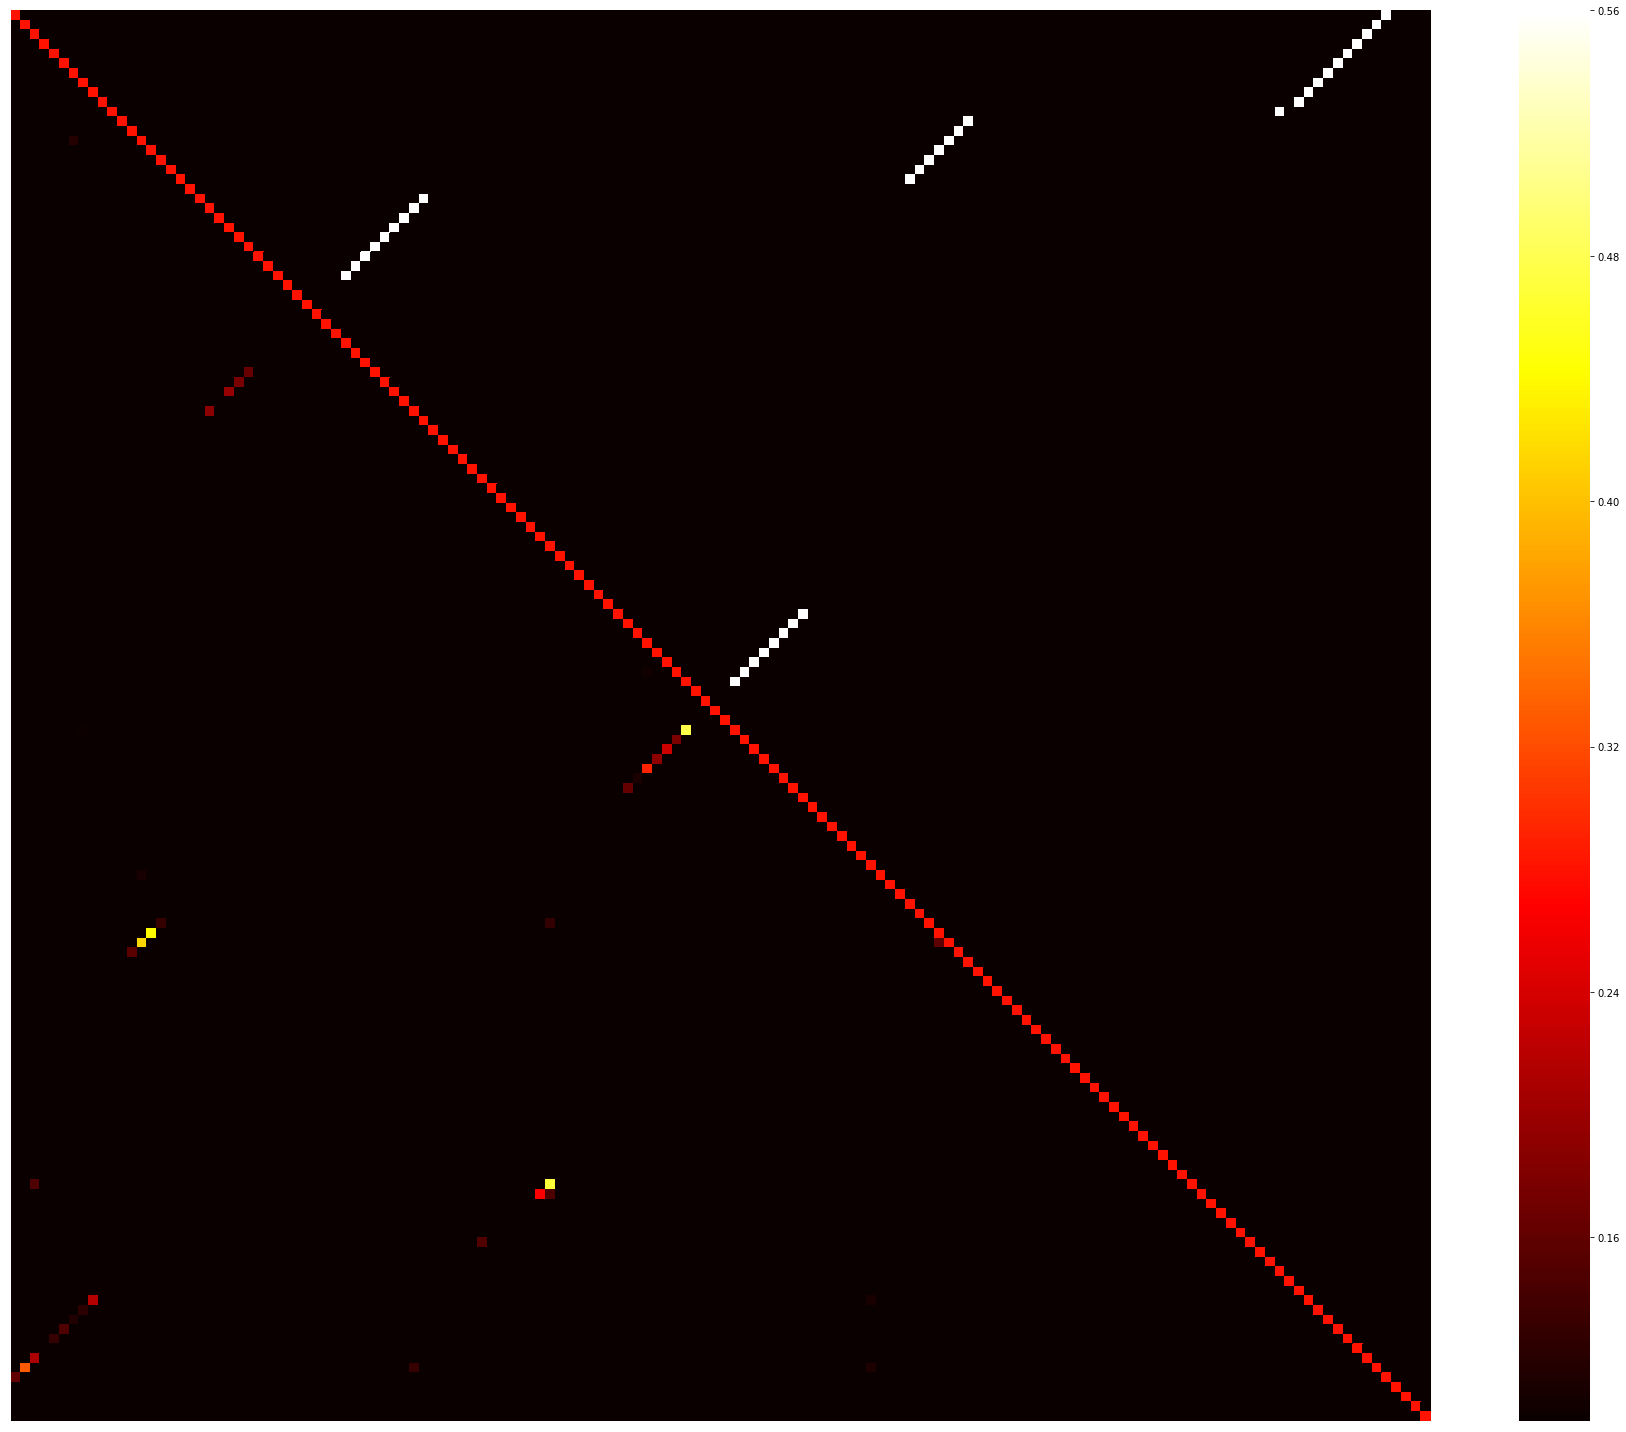

In [23]:
#visualize in the same shape as a wc plot
plt.figure(figsize=(25,20))
sb.heatmap(me,xticklabels=[], yticklabels=[], vmin=0.1, vmax=0.56, cmap='hot', rasterized=True)
plt.xticks(rotation=0, fontsize=20)
plt.yticks(rotation=270, fontsize=20)

plt.savefig('highqual.pdf', format='pdf')

In [23]:
import numpy as np
m = np.tri(np.arange(1, 10, dtype=np.float).reshape(3,3))
m



array([[1., 0., 0.],
       [4., 5., 0.],
       [7., 8., 9.]])

In [22]:
m[np.tril_indices(m.shape[0], -1)] = np.nan
m

array([[ 1.,  2.,  3.],
       [nan,  5.,  6.],
       [nan, nan,  9.]])

In [37]:
m = np.arange(1, 10, dtype=np.float).reshape(3,3)
m[np.triu_indices(3, 1)] = 500.
m

array([[  1., 500., 500.],
       [  4.,   5., 500.],
       [  7.,   8.,   9.]])